In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib.animation as animation
import math
from math import sqrt, cos, sin, acos, atan2, atan, pi
from matplotlib import collections as mc
import numpy as np

In [2]:
def Force2Torque(force = [0,0], force_origin = [0,0], fulcrum = [0,0]):
    radius = np.array(force_origin) - np.array(fulcrum)
    torque = np.cross(radius,np.array(force))
    return torque

def Torque2Force(torque = 0, radius = 0, theta = 0, radius_rot = 0):
    if sin(theta) == 0:
        return np.zeros(2)
    force = torque / radius * sin(theta)
    force_vector = force * np.array([cos(theta-radius_rot),sin(theta-radius_rot)])
    return force_vector

def TranslatePoint(point=[0,0], delta=[0,0]):
    p = np.array(point)
    d = np.array(delta)
    return p+d

def RotatePoint(point=[0,0], theta=0, centre=[0,0]):
    s = sin(-theta)
    c = cos(-theta)
    cnt = np.array(centre)
    rot = np.array([[c, -s],[s, c]])
    p = TranslatePoint(point,-cnt)
    p = np.matmul(p,rot)
    return TranslatePoint(p,cnt)


class Segment:
    def __init__(self, point1 = [0,0], point2 = [0,0], mass = 0) -> None:
        self.point1 = np.array(point1)
        self.point2 = np.array(point2)
        delta = np.subtract(self.point2,self.point1)
        self.length = sqrt(np.sum(np.power(delta,2)))
        if delta[0] == 0:
            self.rot = pi/2
        else:
            self.rot = atan2(delta[1],delta[0])
        self.mass = mass
        self.centre_of_mass = np.zeros(2)
        self.UpdateCentreOfMass()
        
    @classmethod
    def from_point1(cls, point1, length, rot, mass):
        point2 = np.add(np.array(point1),np.multiply(np.array([cos(rot),sin(rot)]),length))
        return cls(point1 = point1, point2 = point2, mass = mass)
    
    @classmethod
    def from_point2(cls, point2, length, rot, mass):
        point1 = np.subtract(np.array(point2),np.multiply(np.array([cos(rot),sin(rot)]),length))
        return cls(point1 = point1, point2 = point2, mass = mass)
    
    def Point2Point(self, clockwise = True):
        if clockwise:
            self.point2 = np.add(np.array(self.point1),np.multiply(np.array([cos(self.rot),sin(self.rot)]),self.length))
        else:
            self.point1 = np.subtract(np.array(self.point2),np.multiply(np.array([cos(self.rot),sin(self.rot)]),self.length))
        self.UpdateCentreOfMass()

    def UpdateCentreOfMass(self):
        self.centre_of_mass = np.add(self.point1,np.divide(np.subtract(self.point2, self.point1),2))

    def UpdateRot(self):
        delta = np.subtract(self.point2,self.point1)
        x1 = self.point1[0]
        x2 = self.point2[0]
        if delta[0] == 0:
            if x2 > x1:
                self.rot = pi/2
            else:
                self.rot = -pi/2
        else:
            self.rot = atan2(delta[1],delta[0])
    
    def UpdateLength(self):
        delta = np.subtract(self.point1,self.point2)
        self.length = sqrt(np.sum(np.power(delta,2)))

    def Update(self, point1=None, point2=None, length=None, rot=None, mass=None):
        if point1 is not None and point2 is not None:
            self.point1 = np.array(point1)
            self.point2 = np.array(point2)
            self.UpdateCentreOfMass()
            self.UpdateLength()
            self.UpdateRot()
        elif point1 is not None and length is not None:
            self.point1 = np.array(point1)
            self.length = length
            self.Point2Point(True)
            self.UpdateCentreOfMass()
        elif point2 is not None and length is not None:
            self.point2 = np.array(point2)
            self.length = length
            self.Point2Point(False)
            self.UpdateCentreOfMass()
        elif point1 is not None and rot is not None:
            self.point1 = np.array(point1)
            self.rot = rot
            self.Point2Point(True)
            self.UpdateCentreOfMass()
        elif point2 is not None and rot is not None:
            self.point2 = np.array(point2)
            self.rot = rot
            self.Point2Point(False)
            self.UpdateCentreOfMass()
        elif length is not None:
            self.length = length
            self.Point2Point(True)
        elif rot is not None:
            self.rot = rot
            self.Point2Point(True)
        elif point1 is not None:
            self.point1 = point1
            self.Point2Point(True)
        elif point2 is not None:
            self.point2 = point2
            self.Point2Point(False)
        if mass is not None:
            self.mass = mass
    
    def Translate(self, vector=[0,0]):
        delta = np.array(vector)
        self.point1 = self.point1 + delta
        self.point2 = self.point2 + delta
        self.centre_of_mass = self.centre_of_mass + delta

    def Rotate(self, angle=0, centre=[0,0]):
        s = sin(-angle)
        c = cos(-angle)
        cnt = np.array(centre)
        rot = np.array([[c, -s],[s, c]])

        self.Translate(-cnt)

        self.point1 = np.matmul(self.point1,rot)
        self.point2 = np.matmul(self.point2,rot)
        
        self.Translate(cnt)
        
        self.UpdateCentreOfMass()
        self.UpdateRot()

    def __str__(self):
        return  f"{self.point1}, {self.point2}"

class Monad:
    def __init__(self, radius = 0.075, density = 1.15e3, relative_core_mass = 1.0) -> None:
        self.radius = radius
        self.density = density
        self.thickness = self.radius / 50

        self.n_faces = 18
        self.n_links = 24

        self.face_length = (2 * self.radius) / (3 * sqrt(2) - 1)
        self.face_volume = self.face_length ** 2 * self.thickness
        self.face_mass = self.face_volume * self.density

        self.link_length = self.radius * ((2 - sqrt(2)) / (3 * sqrt(2) - 1))
        self.link_width = self.face_length / 2
        self.link_volume = self.link_length * self.link_width * self.thickness
        self.link_mass = self.link_volume * self.density

        self.core_position = np.zeros(2)
        self.core_mass = (self.face_mass * self.n_faces + self.link_mass * self.n_links) * relative_core_mass

        self.mass = self.face_mass * self.n_faces + self.link_mass * self.n_links + self.core_mass
        self.centre_of_mass = np.zeros(2)

        self.latch1 = Segment.from_point1([-self.face_length*1.5, self.face_length/2+self.link_length],self.face_length,pi/4,self.face_mass*2)
        self.link1 = Segment.from_point1(self.latch1.point2,self.link_length,0,self.link_mass*2)
        self.actuator1 = Segment.from_point1(self.link1.point2,self.face_length,0,self.face_mass)
        self.link2 = Segment.from_point1(self.actuator1.point2,self.link_length,0,self.link_mass*2)
        self.latch2 = Segment.from_point1(self.link2.point2,self.face_length,-pi/4,self.face_mass*2)
        self.link3 = Segment.from_point1(self.latch2.point2,self.link_length,-pi/2,self.link_mass*2)
        self.actuator2 = Segment.from_point1(self.link3.point2,self.face_length,-pi/2,self.face_mass*4+self.link_mass*4)
        self.link4 = Segment.from_point1(self.actuator2.point2,self.link_length,-pi/2,self.link_mass*2)
        self.latch3 = Segment.from_point1(self.link4.point2,self.face_length,-pi*3/4,self.face_mass*2)
        self.link5 = Segment.from_point1(self.latch3.point2,self.link_length,-pi,self.link_mass*2)
        self.actuator3 = Segment.from_point1(self.link5.point2,self.face_length,-pi,self.face_mass)
        self.link6 = Segment.from_point1(self.actuator3.point2,self.link_length,-pi,self.link_mass*2)
        self.latch4 = Segment.from_point1(self.link6.point2,self.face_length,-pi*5/4,self.face_mass*2)
        self.link7 = Segment.from_point1(self.latch4.point2,self.link_length,-pi*3/2,self.link_mass*2)
        self.actuator4 = Segment.from_point1(self.link7.point2,self.face_length,-pi*3/2,self.face_mass*4+self.link_mass*4)
        self.link8 = Segment.from_point1(self.actuator4.point2,self.link_length,-pi*3/2,self.link_mass*2)

        self.segments = [self.latch1,
                         self.link1,
                         self.actuator1,
                         self.link2,
                         self.latch2,
                         self.link3,
                         self.actuator2,
                         self.link4,
                         self.latch3,
                         self.link5,
                         self.actuator3,
                         self.link6,
                         self.latch4,
                         self.link7,
                         self.actuator4,
                         self.link8]

        self.UpdateCentreOfMass()


    def __str__(self):
        return f"Radius = {self.radius*1000} mm, Density = {self.density} Kg/m3\nFace length = {self.face_length*1000} mm, Link length = {self.link_length*1000}mm\nMonad mass = {self.mass} KG"

    def UpdateCentreOfMass(self):
        
        sumproduct_mass_centre = np.zeros(2)
        for segment in self.segments:
            sumproduct_mass_centre = sumproduct_mass_centre + segment.centre_of_mass * segment.mass

        sumproduct_mass_centre = sumproduct_mass_centre + self.core_mass * self.core_position
        
        self.centre_of_mass = sumproduct_mass_centre / self.mass


    def InverseKinematics(self, actuator_extension):
        x = self.face_length
        y = self.face_length*actuator_extension-self.link_length
        a1 = self.face_length
        a2 = self.link_length
        q2 = acos((x**2+y**2-a1**2-a2**2)/(2*a1*a2))
        q1 = atan(y/x)+atan(a2*sin(q2)/(a1+a2*cos(q2)))

        rot_offset = self.actuator1.rot

        self.latch1.Update(rot=q1+rot_offset)
        self.link1.Update(point1 = self.latch1.point2, rot=q1-q2+rot_offset)
        self.actuator1.Update(point1=self.link1.point2, rot= self.actuator1.rot)#self.link1.point2)
        self.link2.Update(point1=self.actuator1.point2, rot=-(q1-q2)+rot_offset)#2*pi-self.link1.rot)
        self.latch2.Update(point1 = self.link2.point2, rot=-q1+rot_offset)#2*pi-self.latch1.rot)

        self.UpdateCentreOfMass()

    
    def Translate(self, vector=[0,0]):
        vec = np.array(vector)
        for segment in self.segments:
            segment.Translate(vec)
        self.core_position = self.core_position + vec
        self.UpdateCentreOfMass()

    def Rotate(self, angle=0, centre=[0,0]):
        cnt = np.array(centre)
        theta = angle
        for segment in self.segments:
            segment.Rotate(theta, cnt)
        self.core_position = RotatePoint(self.core_position,theta,cnt)
        self.UpdateCentreOfMass()
    
    def Getjoints(self):
        joint_array = []
        for segment in self.segments:
            joint_array.append(segment.point1)
        return np.array(joint_array)
    
def MonadOnMonad(monad_static=Monad, monad_mobile=Monad, piston_extension = 0):
    monad_static.InverseKinematics(piston_extension)
    monad_mobile.InverseKinematics(piston_extension)
    monad_mobile.Rotate(monad_static.latch1.rot-monad_mobile.latch2.rot+pi,monad_static.latch1.point1)

def StaticMonadActuatorForce(monad_static = Monad, monad_mobile = Monad, gravity = [0,-9.8]):

    gravity = np.array(gravity)
    
    latch1_torque = Force2Torque(monad_static.latch1.mass*gravity, monad_static.latch1.centre_of_mass, monad_static.latch1.point1)
    monad_torque = Force2Torque(monad_mobile.mass*gravity, monad_mobile.centre_of_mass, monad_static.latch1.point1)
    latch2_torque = Force2Torque(monad_static.latch2.mass*gravity, monad_static.latch2.centre_of_mass, monad_static.latch2.point2)

    latch1_force = Torque2Force(latch1_torque+monad_torque, monad_static.latch1.length, monad_static.latch1.rot + monad_static.link1.rot, monad_static.latch1.rot)
    latch2_force = Torque2Force(latch2_torque, monad_static.latch2.length, monad_static.latch2.rot + monad_static.link2.rot, monad_static.latch2.rot)
    link1_force = monad_static.link1.mass*gravity
    link2_force = monad_static.link2.mass*gravity
    actuator1_force = monad_static.actuator1.mass * gravity

    actuator_force = latch1_force+link1_force+actuator1_force+latch2_force+link1_force+link2_force

    return actuator_force[1]

def MobileMonadActuatorForce(monad_static = Monad, monad_mobile = Monad, gravity = [0,-9.8]):

    gravity = np.array(gravity)
        
    sumproduct_mass_centre = np.zeros(2)
    mobile_mass = 0
    
    for segment in monad_mobile.segments[2:]:
        sumproduct_mass_centre = sumproduct_mass_centre + segment.centre_of_mass * segment.mass
        mobile_mass = mobile_mass + segment.mass
    
    mobile_mass = mobile_mass + monad_mobile.core_mass
    mobile_centre_of_mass = (sumproduct_mass_centre + monad_mobile.core_mass * monad_mobile.core_position) / mobile_mass

    mobile_monad_torque = Force2Torque(gravity*mobile_mass, mobile_centre_of_mass, monad_mobile.latch2.point2)

    force_latch1 = Torque2Force(mobile_monad_torque,3*monad_mobile.face_length, monad_mobile.latch1.rot, monad_mobile.actuator1.rot)

    force_link1 = force_latch1 * np.array([cos(monad_mobile.link1.rot),sin(monad_mobile.link1.rot)])

    actuator1_force = force_link1 * np.array([cos(monad_mobile.actuator2.rot),sin(monad_mobile.actuator2.rot)])

    return sqrt(np.sum(actuator1_force**2))*np.sign(actuator1_force[0])#*np.sign(actuator1_force[1])

-0.18883213853869468


(-0.15046502829326944,
 0.0798570781014735,
 -0.08250365886663216,
 0.20604322436160138)

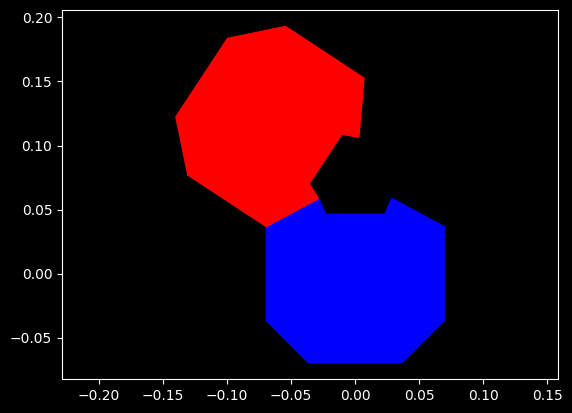

In [3]:
monad1 = Monad()
monad2 = Monad()

monad2.Translate([-3*monad2.face_length,0])
monad2.Rotate(-pi/2, monad1.latch1.point1)

MonadOnMonad(monad1,monad2,0.5)
print(StaticMonadActuatorForce(monad1,monad2))


monad1_outline = ptc.Polygon(monad1.Getjoints(),color='b')
monad2_outline = ptc.Polygon(monad2.Getjoints(),color='r')


fig,ax = plt.subplots()

ax.add_patch(monad1_outline)
ax.add_patch(monad2_outline)

ax.axis('equal')

"monad_outline = ptc.Polygon(monad.Getjoints())\n\nfig,ax = plt.subplots()\n\nax.add_patch(monad_outline)\nax.axis('equal')"

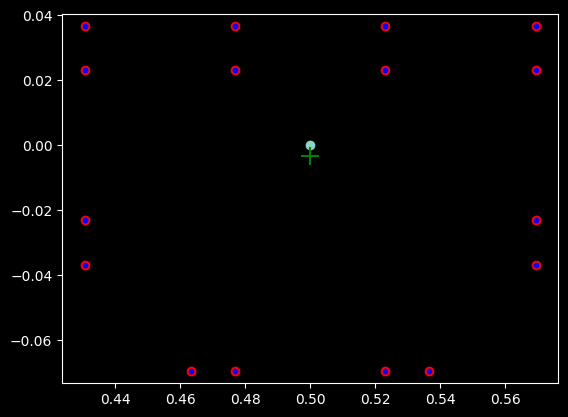

In [4]:
monad = Monad()
#monad.Rotate(-5*pi/6)
monad.Translate([.5,0])
monad.InverseKinematics(0)

plt.scatter(monad.core_position[0],monad.core_position[1])

for segment in monad.segments:
    plt.scatter(segment.point1[0],segment.point1[1],marker='o',c='r')

for segment in monad.segments:
    plt.scatter(segment.point2[0],segment.point2[1],marker='o',c='b', s=10)

plt.scatter(monad.centre_of_mass[0],monad.centre_of_mass[1],marker='+',c='g',s=monad.mass*1000)

plt.axis('equal')

'''monad_outline = ptc.Polygon(monad.Getjoints())

fig,ax = plt.subplots()

ax.add_patch(monad_outline)
ax.axis('equal')'''

In [5]:
monad1 = Monad()
monad2 = Monad()

monad2.Translate([-3*monad2.face_length,0])
monad2.Rotate(-pi/2, monad1.latch1.point1)

force_array_static = []
force_array_mobile = []
steps = 1000

for i in range(steps):
    MonadOnMonad(monad1,monad2,i/steps)
    force_array_static.append(StaticMonadActuatorForce(monad1,monad2))
    force_array_mobile.append(MobileMonadActuatorForce(monad1,monad2))


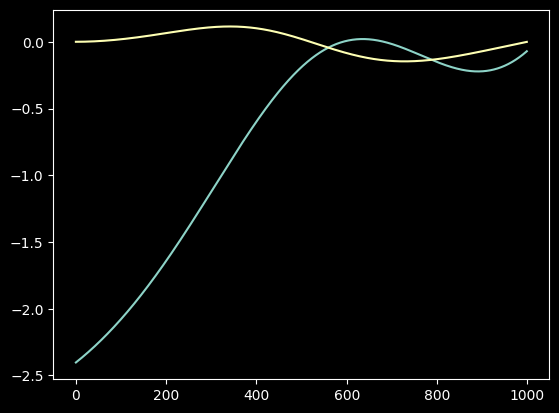

In [6]:
plt.plot(range(steps),force_array_static)
plt.plot(range(steps),force_array_mobile)

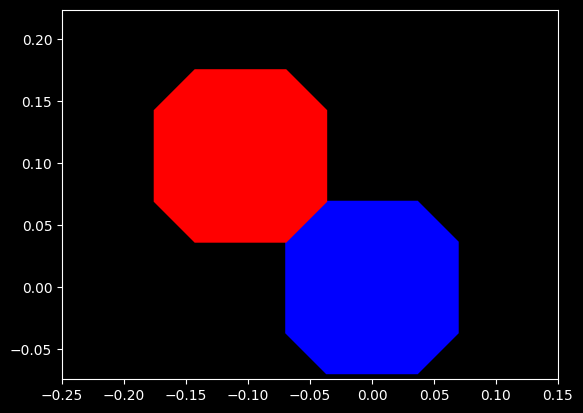

In [7]:
anim_fig = plt.figure()
anim_plot = anim_fig.add_subplot()
steps = 400

monad1 = Monad()
monad2 = Monad()

monad2.Translate([-3*monad2.face_length,0])
monad2.Rotate(-pi/2, monad1.latch1.point1)

monad1_outline = ptc.Polygon(monad1.Getjoints(),color='b')
monad2_outline = ptc.Polygon(monad2.Getjoints(),color='r')

anim_plot.axis('equal')
anim_plot.set_xlim(-0.25, 0.15)
anim_plot.set_ylim(-0.1, 0.25)

anim_plot.add_patch(monad1_outline)
anim_plot.add_patch(monad2_outline)


def init():
    return monad1_outline, monad2_outline

def monadAnimation(i):

    val = abs(200-i)/200
    MonadOnMonad(monad1,monad2,val)

    monad1_outline.set_xy(monad1.Getjoints())
    monad2_outline.set_xy(monad2.Getjoints())

    return monad1_outline, monad2_outline


anim = animation.FuncAnimation(anim_fig, monadAnimation, range(steps), init_func=init)
writergif = animation.PillowWriter(fps=48)
#anim.save("monad_on_monad.gif", writer=writergif)

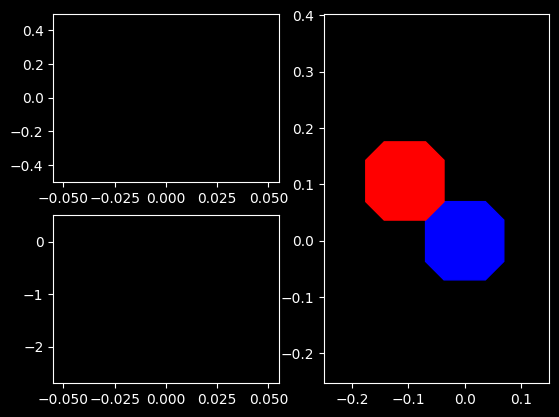

In [8]:
anim_fig = plt.figure()
monad_plot = anim_fig.add_subplot(1,2,2)
static_plot = anim_fig.add_subplot(2,2,3)
mobile_plot = anim_fig.add_subplot(2,2,1, sharex=static_plot)#, sharey=static_plot)
steps = 400

monad1 = Monad()
monad2 = Monad()

monad2.Translate([-3*monad2.face_length,0])
monad2.Rotate(-pi/2, monad1.latch1.point1)

monad1_outline = ptc.Polygon(monad1.Getjoints(),color='b')
monad2_outline = ptc.Polygon(monad2.Getjoints(),color='r')

monad_plot.axis('equal')
monad_plot.set_xlim(-0.25, 0.15)
monad_plot.set_ylim(-0.1, 0.25)

monad_plot.add_patch(monad1_outline)
monad_plot.add_patch(monad2_outline)

static_array = []
mobile_array = []

index_array = []

curve_static, = static_plot.plot([],[])
curve_mobile, = mobile_plot.plot([],[])

def init():
    curve_static.set_data([],[])
    curve_static.set_data([],[])
    monad_plot.axis('equal')
    monad_plot.set_xlim(-0.25, 0.15)
    monad_plot.set_ylim(-0.1, 0.25)
    static_plot.set_ylim(-2.7,0.5)
    mobile_plot.set_ylim(-0.5,0.5)
    return monad1_outline, monad2_outline#, curve_static, curve_mobile

def monadAnimation(i):

    val = abs(200-i)/200
    MonadOnMonad(monad1,monad2,val)

    monad1_outline.set_xy(monad1.Getjoints())
    monad2_outline.set_xy(monad2.Getjoints())

    force_static = StaticMonadActuatorForce(monad1, monad2)
    force_mobile = MobileMonadActuatorForce(monad1, monad2)

    '''static_array.append(force_static)
    mobile_array.append(force_mobile)

    index_array.append(i)

    curve_static.set_data(index_array,static_array)
    curve_mobile.set_data(index_array,mobile_array)'''

    static_plot.scatter(i,force_static,c='b')
    mobile_plot.scatter(i,force_mobile,c='r')

    return monad1_outline, monad2_outline, curve_static, curve_mobile


anim = animation.FuncAnimation(anim_fig, monadAnimation, range(steps), init_func=init)
writergif = animation.PillowWriter(fps=48)
#anim.save("monads_with_forces.gif", writer=writergif)

In [9]:
print(monad1)

Radius = 75.0 mm, Density = 1150.0 Kg/m3
Face length = 46.258594298111326 mm, Link length = 13.548828581759444mm
Monad mass = 0.15883259388729387 KG
